# Uma análise da utilização do Keras na predição de diagnósticos de eletrocardiogramas utilizando a base PTB-XL


### Projeto de conclusão da pós-graduação BI-MASTER na PUC-RJ 

**Aluno: [Alaor Barroso de Carvalho Neto](mailto:alaorneto@gmail.com)**

**Orientadora: [DSc Manoela Kohler](prof.manoela@ica.ele.puc-rio.br)**

Este trabalho utiliza a base de dados PTB-XL, base aberta de eletrocardiogramas, que inclui os sinais obtidos com os procedimentos e as anotações de diagnóstico realizadas por profissionais médicos.

## Objetivo

Investigar a utilização de modelos de inteligência artificial treinados a partir das anotações realizadas por médicos como alternativa para predição de diagnóstico em novos exames expostos aos modelos.

Este trabalho buscará:
- Apresentar o modelo dos dados e realizar uma análise exploratória dos dados
- Realizar o tratamento dos dados para preparação para uso nas redes
- Investigar as melhores opções de configuração de redes para o caso proposto
- Desenvolver e comparar modelos de IA quanto à eficácia na predição de dianósticos

## Descrição geral dos arquivos

- `records100/`: armazena os valores dos eletrocardiogramas com taxa de amostragem de 100Hz
- `records500/`: armazena os valores dos eletrocardiogramas com taxa de amostragem de 500Hz
- `ptbxl_database.csv`: possui um índice de todos os exames realizados, com algumas informações demográficas do paciente, anotação do diagnóstico, forma e ritmo, entre outras informações médicas
- `scp_statements.csv`: possui o catálogo de todas as códigos utilizados nas anotações de diagnóstico, forma e ritmo

Este trabalho se concentrará na aálise das anotações de diagnóstico, deste modo, caso algum eletrocardiograma possua apenas anotações de forma e/ou ritmo, serão descartados da análise.

## Importação das bibliotecas

Este trabalho baseou-se no framework Keras como forma de construir as redes para inferência dos diagnósticos.

O Keras e outras bibliotecas de apoio utilizadas são importadas abaixo.

In [46]:
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import preprocessing
from tensorflow.keras.layers.experimental import RandomFourierFeatures
import pandas as pd
import numpy as np
import tensorflow as tf
import wfdb
import ast
import itertools
import matplotlib.pyplot as plt
import operator
import networkx as nx
from graph_utils import scp_graph

As constantes abaixo trazem parâmetros úteis para o programa, como taxa de amostragem padrão a ser utilizada, número de ondas, entre outras.

In [7]:
PATH = './'
SAMPLING_RATE = 100
NUM_LEADS = 12
NUM_SECONDS = 10
TEST_FOLD = 10

## Carregamento e análise de dados gerais sobre exames

A análise exploratória inicia com o carregamento dos dados gerais sobre diagnósticos que constam da base de dados.

In [8]:
Y = pd.read_csv(PATH+'ptbxl_database.csv', index_col='ecg_id')
Y

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21833,17180.0,67.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-05-31 09:14:35,ventrikulÄre extrasystole(n) sinustachykardie ...,...,True,NaN,", alles,",NaN,NaN,1ES,NaN,7,records100/21000/21833_lr,records500/21000/21833_hr
21834,20703.0,93.0,0,NaN,NaN,1.0,2.0,AT-60 3,2001-06-05 11:33:39,sinusrhythmus lagetyp normal qrs(t) abnorm ...,...,True,NaN,NaN,NaN,NaN,NaN,NaN,4,records100/21000/21834_lr,records500/21000/21834_hr
21835,19311.0,59.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-08 10:30:27,sinusrhythmus lagetyp normal t abnorm in anter...,...,True,NaN,", I-AVR,",NaN,NaN,NaN,NaN,2,records100/21000/21835_lr,records500/21000/21835_hr


Particularmente, a coluna `scp_codes` é uma das mais importantes nesse contexto, pois ela inclui os códigos utilizados pelos médicos para anotar cada um dos exames realizados.

Os códigos estão associados a um valor, que representa a probabilidade daquela característica. Valores 0.0 indicam que há incerteza sobre a probabilidade, e não que aquela característica não está presente, por isso devem ser considerados.

In [9]:
# Converte no formato dicionário
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))
Y.scp_codes

ecg_id
1                 {'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}
2                             {'NORM': 80.0, 'SBRAD': 0.0}
3                               {'NORM': 100.0, 'SR': 0.0}
4                               {'NORM': 100.0, 'SR': 0.0}
5                               {'NORM': 100.0, 'SR': 0.0}
                               ...                        
21833    {'NDT': 100.0, 'PVC': 100.0, 'VCLVH': 0.0, 'ST...
21834             {'NORM': 100.0, 'ABQRS': 0.0, 'SR': 0.0}
21835                           {'ISCAS': 50.0, 'SR': 0.0}
21836                           {'NORM': 100.0, 'SR': 0.0}
21837                           {'NORM': 100.0, 'SR': 0.0}
Name: scp_codes, Length: 21837, dtype: object

### Carregamento do arquivo scp_statements.csv

O arquivo `scp_statements.csv` possui a descrição de todas as anotações de diagnóstico utilizadas pelos médicos, assim como anotações de forma e ritmo, e outros dados relacionados às anotações.

Dentro do arquivo, as anotações estão organizadas em uma superclasse e uma subclasse, como forma de detalhar a hierarquia das anotações.

In [10]:
scp_statements = pd.read_csv(PATH+'scp_statements.csv', index_col=0)

Para fins deste trabalho, apenas as anotações do tipo 'diagnóstico' serão utilizadas.

Desse modo, o conteúdo de `scp_statements` é filtrado para garantir que não serão analisadas anotações de forma e/ou ritmo.

O diagrama a seguir representa a hierarquia das anotações de diagnóstico, a partir da classe, passando pela subclasse, até a anotação propriamente dita.

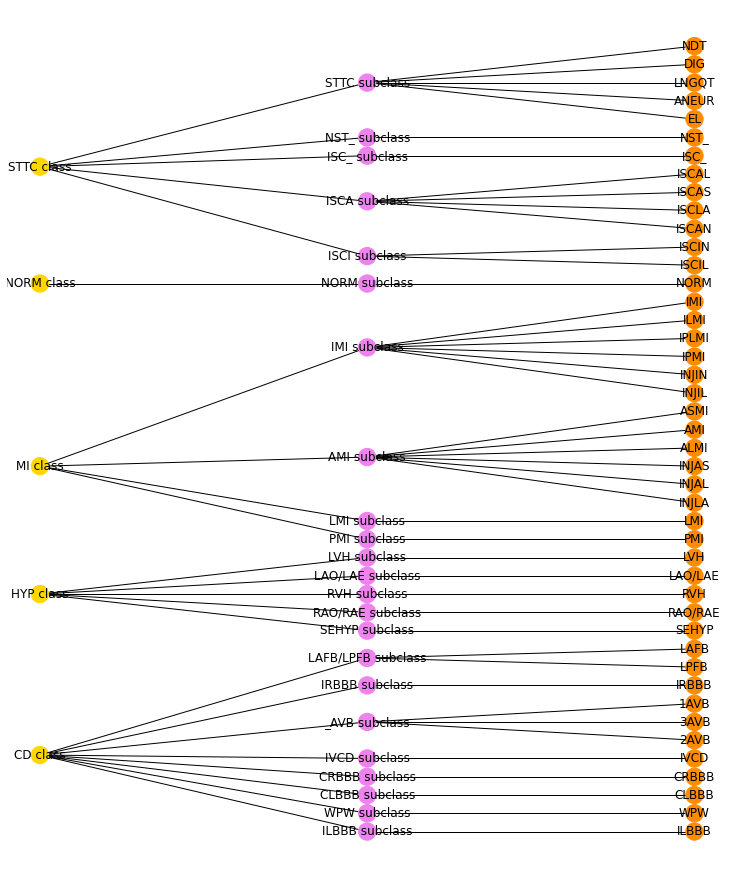

In [50]:
_scp_graph = scp_graph(scp_statements)
plt.figure(figsize=(10, 12))
nx.draw(_scp_graph['G'], _scp_graph['pos'], node_color=_scp_graph['color'], with_labels=True)
plt.show()

O código a seguir realiza o filtro e exibe os códigos de diagnóstico resultantes.

In [11]:
diagnostics = scp_statements[scp_statements.diagnostic == 1].sort_index()
diagnostics_codes = diagnostics.index.unique()
diagnostics_codes

Index(['1AVB', '2AVB', '3AVB', 'ALMI', 'AMI', 'ANEUR', 'ASMI', 'CLBBB',
       'CRBBB', 'DIG', 'EL', 'ILBBB', 'ILMI', 'IMI', 'INJAL', 'INJAS', 'INJIL',
       'INJIN', 'INJLA', 'IPLMI', 'IPMI', 'IRBBB', 'ISCAL', 'ISCAN', 'ISCAS',
       'ISCIL', 'ISCIN', 'ISCLA', 'ISC_', 'IVCD', 'LAFB', 'LAO/LAE', 'LMI',
       'LNGQT', 'LPFB', 'LVH', 'NDT', 'NORM', 'NST_', 'PMI', 'RAO/RAE', 'RVH',
       'SEHYP', 'WPW'],
      dtype='object')

Em seguida, verificamos a quantidade de classes de anotação de diagnóstico possíveis.

In [12]:
qt_diagnostics_codes = diagnostics_codes.shape[0]
qt_diagnostics_codes

44

### Saneamento dos dados de dianóstico

A coluna de anotação de diagnósticos é filtrada, retirando-se as anotações de forma e ritmo.

In [13]:
""" Filtra apenas os scp_codes relacionados à anotações do tipo diagnóstico """
def filter_diagnostics(y_dict):
    new_dict = {k: v for k, v in y_dict.items() if (diagnostics.index == k).any()}
    return new_dict

Y['scp_diagnostic_codes'] = Y.scp_codes.apply(filter_diagnostics)
Y.scp_diagnostic_codes

ecg_id
1        {'NORM': 100.0}
2         {'NORM': 80.0}
3        {'NORM': 100.0}
4        {'NORM': 100.0}
5        {'NORM': 100.0}
              ...       
21833     {'NDT': 100.0}
21834    {'NORM': 100.0}
21835    {'ISCAS': 50.0}
21836    {'NORM': 100.0}
21837    {'NORM': 100.0}
Name: scp_diagnostic_codes, Length: 21837, dtype: object

## Preparação dos dados

Um determinado exame pode ter uma ou mais anotações do tipo diagnóstico, que, conjuntamente, representarão o diagóstico integral daquele paciente.


### Criação da matriz multi-hot

Uma vez que as anotações de diagnóstico não são categorias exclusivas, foi feita a opção pela modelagem do problema através de uma matriz 'multi-hot', onde cada possível anotação de diagnóstico será analisada invidualmente de forma binária.

Para isso, são criadas colunas adicionais nas informações sobre os exames, sendo uma coluna para cada possível anotação de diagnóstico, e são preenchidos valores iniciais '0.0' para cada entrada.

In [14]:
Y[[diagnostics_codes]] = 0.0
Y.columns

Index(['patient_id', 'age', 'sex', 'height', 'weight', 'nurse', 'site',
       'device', 'recording_date', 'report', 'scp_codes', 'heart_axis',
       'infarction_stadium1', 'infarction_stadium2', 'validated_by',
       'second_opinion', 'initial_autogenerated_report', 'validated_by_human',
       'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems',
       'extra_beats', 'pacemaker', 'strat_fold', 'filename_lr', 'filename_hr',
       'scp_diagnostic_codes', '1AVB', '2AVB', '3AVB', 'ALMI', 'AMI', 'ANEUR',
       'ASMI', 'CLBBB', 'CRBBB', 'DIG', 'EL', 'ILBBB', 'ILMI', 'IMI', 'INJAL',
       'INJAS', 'INJIL', 'INJIN', 'INJLA', 'IPLMI', 'IPMI', 'IRBBB', 'ISCAL',
       'ISCAN', 'ISCAS', 'ISCIL', 'ISCIN', 'ISCLA', 'ISC_', 'IVCD', 'LAFB',
       'LAO/LAE', 'LMI', 'LNGQT', 'LPFB', 'LVH', 'NDT', 'NORM', 'NST_', 'PMI',
       'RAO/RAE', 'RVH', 'SEHYP', 'WPW'],
      dtype='object')

Então, são ativadas (1) as características que constam do diagnóstico anotado pelos médicos.

In [15]:
for index, row in Y.iterrows():
    for k, v in row.scp_diagnostic_codes.items():
        Y.loc[index, k] = 1

### Limpeza de exames sem diagnóstico

Os exames que possuem anotações vazias após a exclusão das anotações de forma e ritmo são descartados da análise.

In [11]:
Y = Y.loc[(Y.scp_diagnostic_codes!={})]

## Carregamento e preparação dos valores medidos nos exames

Os valores dos exames estão salvos nas pastas `records100` e `records500`, respectivamente, armazenando os dados em 100Hz e 500Hz.

A função `load_raw_data` é responsável por carregar os valores dos exames a partir de uma lista de ids informados, extraídos do arquivo `ptbxl_database.csv`, e da taxa de amostragem (sampling rate) desejada, configurada nas constantes no início do programa.

In [12]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

X = load_raw_data(Y, SAMPLING_RATE, PATH)

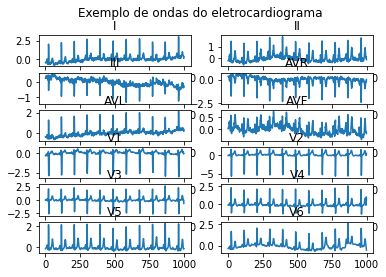

In [58]:
fig, axs = plt.subplots(6,2)
fig.suptitle('Exemplo de ondas do eletrocardiograma')
axs[0,0].set_title('I')
axs[0,0].plot(list(map(operator.itemgetter(0), X[0])))
axs[0,1].set_title('II')
axs[0,1].plot(list(map(operator.itemgetter(1), X[0])))
axs[1,0].set_title('III')
axs[1,0].plot(list(map(operator.itemgetter(2), X[0])))
axs[1,1].set_title('AVR')
axs[1,1].plot(list(map(operator.itemgetter(3), X[0])))
axs[2,0].set_title('AVL')
axs[2,0].plot(list(map(operator.itemgetter(4), X[0])))
axs[2,1].set_title('AVF')
axs[2,1].plot(list(map(operator.itemgetter(5), X[0])))
axs[3,0].set_title('V1')
axs[3,0].plot(list(map(operator.itemgetter(6), X[0])))
axs[3,1].set_title('V2')
axs[3,1].plot(list(map(operator.itemgetter(7), X[0])))
axs[4,0].set_title('V3')
axs[4,0].plot(list(map(operator.itemgetter(8), X[0])))
axs[4,1].set_title('V4')
axs[4,1].plot(list(map(operator.itemgetter(9), X[0])))
axs[5,0].set_title('V5')
axs[5,0].plot(list(map(operator.itemgetter(10), X[0])))
axs[5,1].set_title('V6')
axs[5,1].plot(list(map(operator.itemgetter(11), X[0])))


### Normalização z-score 

Os valores medidos nos exames já seguem uma escala de variação do sinal elétrico que guarda consistência entre os exames.

Entretanto, como forma de evitar qualquer distorção pontual, os valores dos exames são normalizados pela função z-score.

In [13]:
x_mean = np.mean(X)
x_std = np.std(X)
X = (X-x_mean)/x_std

## Preparação dos dados

Nesta etapa, os dados de valores dos exames são separados em um conjunto de treinamento e de testes, para serem utilizados nos modelos de IA.

Primeiro, trabalhamos nos conjuntos de treinamento.

In [14]:
x_train = X[np.where(Y.strat_fold != TEST_FOLD)]
y_train = Y[(Y.strat_fold != TEST_FOLD)][Y.columns[(-1 * qt_diagnostics_codes):]]

As colunas de resultado no formato 'multi-hot' são destacadas abaixo.

In [15]:
y_train.columns

Index(['1AVB', '2AVB', '3AVB', 'ALMI', 'AMI', 'ANEUR', 'ASMI', 'CLBBB',
       'CRBBB', 'DIG', 'EL', 'ILBBB', 'ILMI', 'IMI', 'INJAL', 'INJAS', 'INJIL',
       'INJIN', 'INJLA', 'IPLMI', 'IPMI', 'IRBBB', 'ISCAL', 'ISCAN', 'ISCAS',
       'ISCIL', 'ISCIN', 'ISCLA', 'ISC_', 'IVCD', 'LAFB', 'LAO/LAE', 'LMI',
       'LNGQT', 'LPFB', 'LVH', 'NDT', 'NORM', 'NST_', 'PMI', 'RAO/RAE', 'RVH',
       'SEHYP', 'WPW'],
      dtype='object')

O formato do conjunto de dados de treinamento.

In [16]:
x_train.shape

(19267, 1000, 12)

Agora, preparamos os conjuntos de testes.

In [17]:
x_test = X[np.where(Y.strat_fold == TEST_FOLD)]
y_test = Y[Y.strat_fold == TEST_FOLD][Y.columns[(-1 * qt_diagnostics_codes):]]

## Construção dos modelos

Esta seção é responsável por criar os modelos que serão treinados e testados para aferir a eficácia ao estimar os diagnósticos.

### Construção do modelo Convolucional 1D

O modelo convolucional de 1D foi escolhido, apesar de ser majoritariamente conhecido pelo uso na utilização de imagens, pois também tem sido utilizado com frequência na classificação de séries temporais, e, pelo formato dos dados no problema, que contém valores de medição em 12 derivações diferentes.

Uma vez que a modelagem do problema foi construída em cima de um cenário 'multi-hot', o layer de classificação foi designado para utilizar a função sigmoid.

In [34]:
def make_model_conv1D(input_shape):
    model = keras.Sequential()

    model.add(layers.SeparableConv1D(filters=64, kernel_size=1, padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    
    model.add(layers.SeparableConv1D(filters=64, kernel_size=3, padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.SeparableConv1D(filters=64, kernel_size=1, padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.GlobalAveragePooling1D())

    model.add(layers.Dense(128, activation="relu"))

    model.add(layers.Dense(qt_diagnostics_codes, activation="sigmoid"))

    return model

O sumário do modelo Conv1D construído.

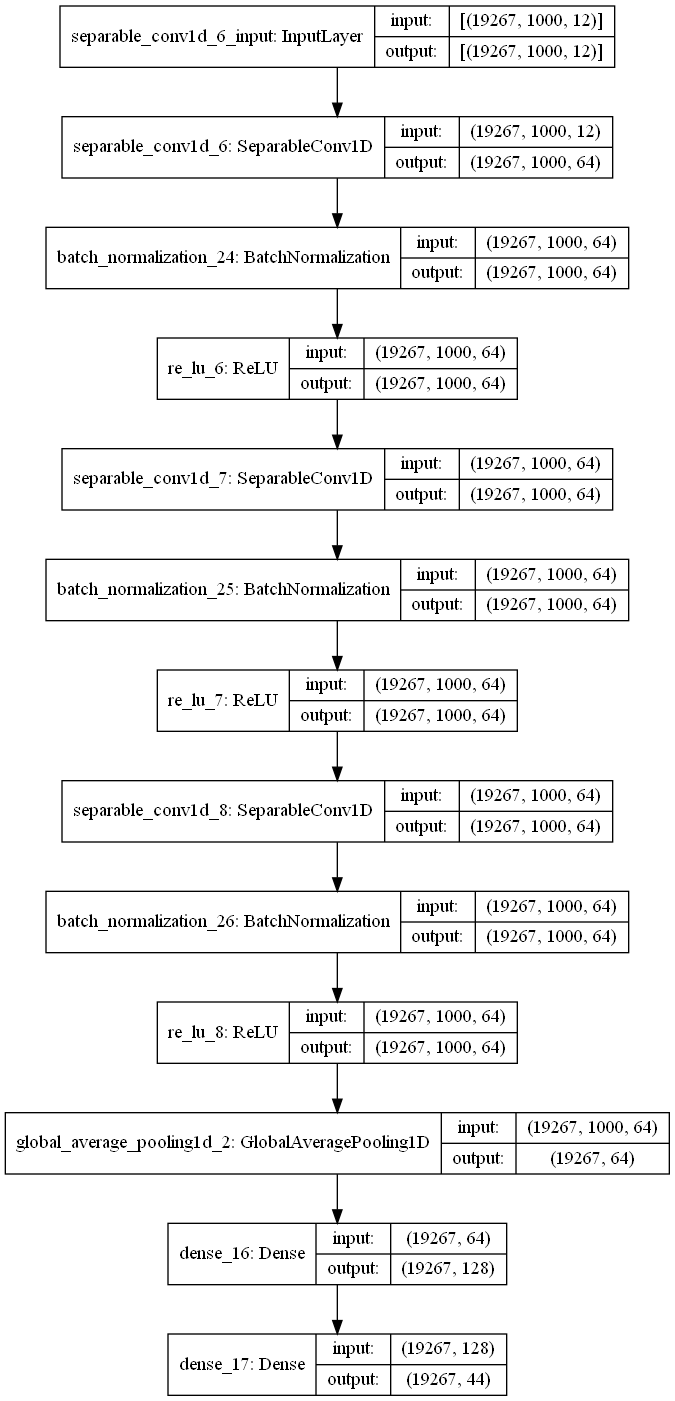

In [35]:
model_conv1D = make_model_conv1D(input_shape=x_train.shape)
model_conv1D.build(input_shape=x_train.shape)
keras.utils.plot_model(model_conv1D, show_shapes=True)

### Construção do modelo LSTM

Os modelos Long Short-Term Memory são especialmente conhecidos por sua utilização na classificação de séries temporais, aplicando-se portanto ao domínio deste trabalho.

Do mesmo modo, pela modelagem multi-hot, o último layer utiliza a função sigmoid.

In [20]:
def make_model_lstm(input_shape):
    model = keras.Sequential()
    
    model.add(layers.Bidirectional(layers.LSTM(
        qt_diagnostics_codes,
        activation="tanh",
        recurrent_activation="sigmoid",
        use_bias=True,
        kernel_initializer="glorot_uniform",
        recurrent_initializer="orthogonal",
        return_sequences=True
    )))

    model.add(layers.BatchNormalization())

    model.add(layers.LSTM(
        qt_diagnostics_codes,
        activation="tanh",
        recurrent_activation="sigmoid",
        use_bias=True,
        kernel_initializer="glorot_uniform",
        recurrent_initializer="orthogonal"
    ))

    model.add(layers.Dropout(0.2))
    
    model.add(layers.BatchNormalization())

    model.add(layers.Dense(128, kernel_regularizer=keras.regularizers.l2(l=0.01), activation="relu"))
    
    model.add(layers.Dropout(0.2))
    
    model.add(layers.BatchNormalization())
    
    model.add(layers.Dense(qt_diagnostics_codes, activation="sigmoid"))
    
    return model

O sumário do modelo LSTM construído.

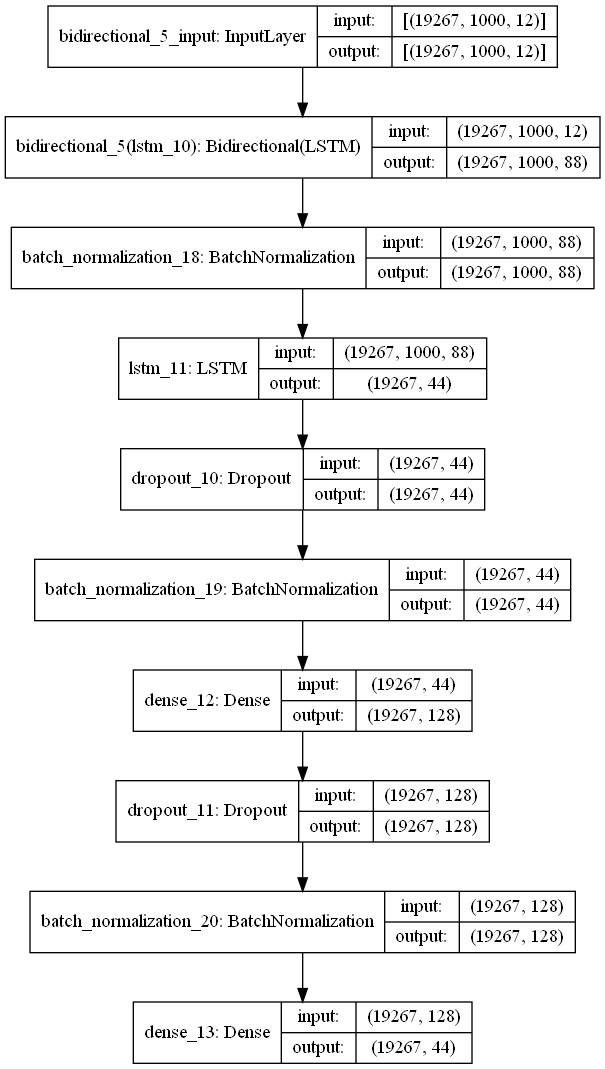

In [31]:
model_lstm = make_model_lstm(input_shape=x_train.shape)
model_lstm.build(input_shape=x_train.shape)
keras.utils.plot_model(model_lstm, show_shapes=True)

## Treinamento dos modelos

Nesta etapa os modelos são expostos aos exames e suas saídas são comparadas às anotações realizadas pelos médicos, como forma de apurar a diferença na previsão e ajustar os parâmetros da rede em cima do erro identificado, de forma a torná-la mais apta em futuras iterações.

### Treinamento do modelo LTSM

O modelo é compilado utilizando-se a função de perda `binary_crossentropy` e a função de acurácia `binary_accuracy`, em razão da modelagem multi-hot utilizada no problema.

In [22]:
epochs = 30
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "./lstm_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.2, patience=5, min_lr=0.001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model_lstm.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["binary_accuracy"],
)
history = model_lstm.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/30
482/482 [==============================] - 430s 878ms/step - loss: 0.3508 - binary_accuracy: 0.8917 - val_loss: 0.1135 - val_binary_accuracy: 0.9685
Epoch 2/30
482/482 [==============================] - 399s 827ms/step - loss: 0.1042 - binary_accuracy: 0.9711 - val_loss: 0.1072 - val_binary_accuracy: 0.9696
Epoch 3/30
482/482 [==============================] - 382s 793ms/step - loss: 0.0979 - binary_accuracy: 0.9719 - val_loss: 0.1047 - val_binary_accuracy: 0.9674
Epoch 4/30
482/482 [==============================] - 386s 800ms/step - loss: 0.0949 - binary_accuracy: 0.9724 - val_loss: 0.0972 - val_binary_accuracy: 0.9711
Epoch 5/30
482/482 [==============================] - 368s 763ms/step - loss: 0.0900 - binary_accuracy: 0.9731 - val_loss: 0.1007 - val_binary_accuracy: 0.9694
Epoch 6/30
482/482 [==============================] - 372s 771ms/step - loss: 0.0873 - binary_accuracy: 0.9738 - val_loss: 0.0917 - val_binary_accuracy: 0.9711
Epoch 7/30
482/482 [====================

### Treinamento do modelo Convolucional 1D
Da mesma forma, o modelo é compilado utilizando-se a função de perda `binary_crossentropy` e a função de acurácia `binary_accuracy`.

In [24]:
epochs = 30
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "./conv1d_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.2, patience=5, min_lr=0.001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model_conv1D.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["binary_accuracy"],
)
history = model_conv1D.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/30
482/482 [==============================] - 63s 125ms/step - loss: 0.1161 - binary_accuracy: 0.9663 - val_loss: 0.0997 - val_binary_accuracy: 0.9703
Epoch 2/30
482/482 [==============================] - 59s 123ms/step - loss: 0.0815 - binary_accuracy: 0.9746 - val_loss: 0.0846 - val_binary_accuracy: 0.9735
Epoch 3/30
482/482 [==============================] - 60s 125ms/step - loss: 0.0766 - binary_accuracy: 0.9756 - val_loss: 0.0813 - val_binary_accuracy: 0.9737
Epoch 4/30
482/482 [==============================] - 61s 126ms/step - loss: 0.0734 - binary_accuracy: 0.9764 - val_loss: 0.0768 - val_binary_accuracy: 0.9748
Epoch 5/30
482/482 [==============================] - 65s 135ms/step - loss: 0.0704 - binary_accuracy: 0.9770 - val_loss: 0.0753 - val_binary_accuracy: 0.9753
Epoch 6/30
482/482 [==============================] - 73s 152ms/step - loss: 0.0685 - binary_accuracy: 0.9775 - val_loss: 0.0729 - val_binary_accuracy: 0.9761
Epoch 7/30
482/482 [==========================

## Testes e comparação dos modelos

Após o treinamento dos modelos, eles são expostos aos conjuntos de teste, para verificar sua performance com dados ainda desconhecidos pelas redes.

In [36]:
print("LSTM - resultados")

model = keras.models.load_model("./lstm_model.h5")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

print("-------\n")

print("Conv1D - resultados")

model = keras.models.load_model("./conv1d_model.h5")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

print("-------\n")

LSTM - resultados
68/68 [==============================] - 11s 148ms/step - loss: 0.0684 - binary_accuracy: 0.9791
Test accuracy 0.9791008830070496
Test loss 0.06839613616466522
-------

Conv1D - resultados
68/68 [==============================] - 2s 21ms/step - loss: 0.0622 - binary_accuracy: 0.9790
Test accuracy 0.9790065884590149
Test loss 0.06222653388977051
-------



## Conclusão

Ambos os modelos Convolucional e Long Short-Term Memory se mostraram aptos a realizar a inferência de diagnósticos em eletrocardiogramas constantes da base de dados PTB-XL, com excelente nível de acurácia na fase de testes, com cerca de 97,9% de acurácia cada.



## Referências

- [PTB-XL, a large publicly available electrocardiography dataset](https://physionet.org/content/ptb-xl/1.0.1/)
- [Deep Learning for ECG Analysis: Benchmarks and Insights from PTB-XL](https://www.researchgate.net/publication/344215052_Deep_Learning_for_ECG_Analysis_Benchmarks_and_Insights_from_PTB-XL)
- [How to solve Multi-Label Classification Problems in Deep Learning with Tensorflow & Keras?](https://medium.com/deep-learning-with-keras/how-to-solve-multi-label-classification-problems-in-deep-learning-with-tensorflow-keras-7fb933243595)

{'G': <networkx.classes.graph.Graph object at 0x000002C23D936430>, 'pos': {'CD class': array([-0.07170543, -0.80523256]), 'HYP class': array([-0.07170543, -0.39534884]), 'MI class': array([-0.07170543, -0.06976744]), 'NORM class': array([-0.07170543,  0.39534884]), 'STTC class': array([-0.07170543,  0.69302326]), 'ILBBB subclass': array([-0.0251938, -1.       ]), 'WPW subclass': array([-0.0251938 , -0.95348837]), 'CLBBB subclass': array([-0.0251938 , -0.90697674]), 'CRBBB subclass': array([-0.0251938 , -0.86046512]), 'IVCD subclass': array([-0.0251938 , -0.81395349]), '_AVB subclass': array([-0.0251938 , -0.72093023]), 'IRBBB subclass': array([-0.0251938 , -0.62790698]), 'LAFB/LPFB subclass': array([-0.0251938 , -0.55813953]), 'SEHYP subclass': array([-0.0251938 , -0.48837209]), 'RAO/RAE subclass': array([-0.0251938 , -0.44186047]), 'RVH subclass': array([-0.0251938 , -0.39534884]), 'LAO/LAE subclass': array([-0.0251938 , -0.34883721]), 'LVH subclass': array([-0.0251938 , -0.30232558])

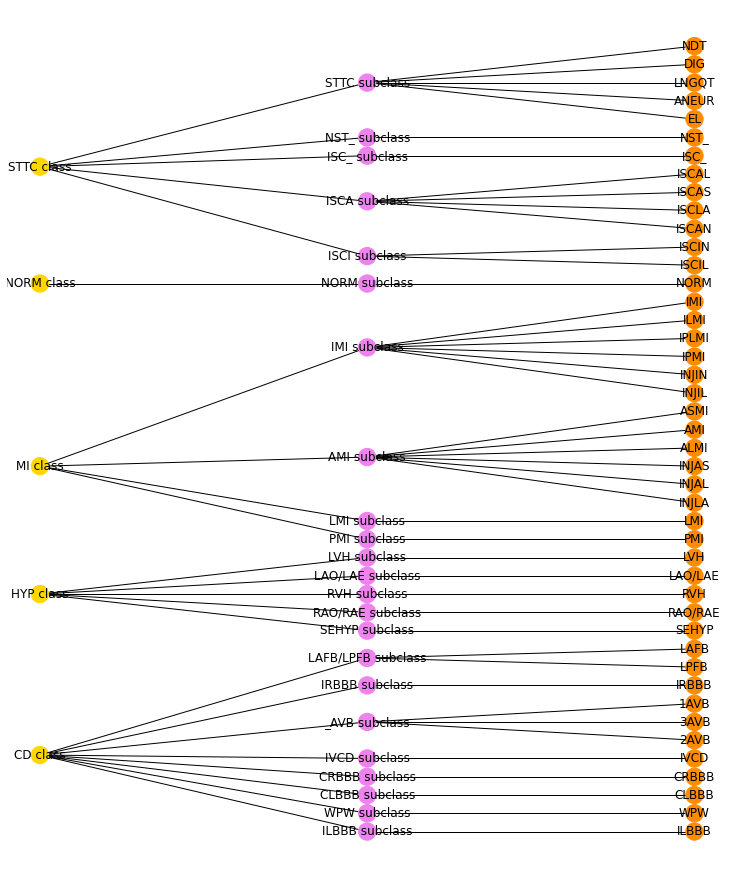

In [49]:
_scp_graph = scp_graph(scp_statements)
plt.figure(figsize=(10, 12))
nx.draw(_scp_graph['G'], _scp_graph['pos'], node_color=_scp_graph['color'], with_labels=True)
plt.show()